 
# SIParCS Machine Learning Dense

This is a notebook for recreating McKinnon et al. 2016 work. 

# Import Packages

In [1]:
#!/usr/bin/env python
%matplotlib inline

import subprocess
import os
import glob
import sys
import re
import csv
import netCDF4 as nc  
import numpy as np
import datetime
import pandas as pd
import matplotlib.pylab as plt
import datetime as dt
from tqdm import tqdm
import load_sst_data
import load_station_data
from load_station_data import *
#from sklearn.cluster import AgglomerativeClustering

#from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward



# Functions

## DATA IMPORT 
### I- GHCN CLIMATE DATA (STATION DATA)

The Global Historical Climatology Network (GHCN) has daily weather data from +106,000 weather stations in 180 countries and territories (see https://www.ncdc.noaa.gov/oa/climate/ghcn-daily/). 



In [2]:
# Can put all three of these functions in one function for example all_stations_data (....)

def get_ghcnd_stn (ghcnd_csv_dir, stn_id, start_year, end_year, start_doy, end_doy):
            '''
            get_ghcnd_stn:
                *Opens the csv file for the GHCND station as df
                *Add a pd.datetime column to the df
                *Add Julian Day (day of the year) jday to the df 
                *Selects data for only the trianing years
                *Selects data for only the selected days of a year ( e.g. 60 days of summer.) 
                
            ----------
            Parameters:
                ghcnd_csv_dir --- path to GHCN processed csv files.
                stn_id --- GHCN station ID based on GHCN readme.txt
                    (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
                
                start_year --- start year for the period to slice. 
                end_year 
                
                start_doy  --- start julian day (day of year) for the period
                                you are looking at.  
                end_doy
            -------
            Returns:
                stn_data --- 
            
            -------
            Example:
                stn_data = get_ghcnd_stn(ghcnd_csv_dir,stn_id,1982,
                            2015, 30, 90)
                
            '''
            
            stn_csv = ghcnd_csv_dir+stn_id+'.csv'

            stn_raw = pd.read_csv(stn_csv,na_values=-9999)
            
            stn_raw['date']=pd.to_datetime(stn_raw['YYYY'].astype(str)+'-'+stn_raw['MM'].astype(str)+'-'+stn_raw['DD'].astype(str))
            stn_raw['jday'] = stn_raw['date'].dt.dayofyear.apply(lambda x: str(x).zfill(3)).astype(int)
            #print ( 'file ' + stn_csv +' is processed!')
            
            #print stn_raw['YYYY'].max()
            #print stn_raw['YYYY'].min()
            line = 'Data for '+ stn_id + ' is avialble for : ' \
                    + str(stn_raw['YYYY'].min()) +' '\
                    + str(stn_raw['YYYY'].max())
            #print (line)

            ##processing based on year and days

            yrs_data = stn_raw[(stn_raw['YYYY']>=start_year) & (stn_raw['YYYY']<=end_year)]
            stn_data= yrs_data[(yrs_data['jday']>=start_doy) & (yrs_data['jday']<=end_doy)]
            
            #print ('DONE!')
            return stn_data 
        

def calc_stn_anom (stn_data, var):
            '''
            calc_stn_anom :
                *Calculates the anomalies of selected var for the station.
            ----------
            Parameters:
                stn_data ---
                var --- Name of the varibale to calculate anomalies on :
                        e.g. TMAX, TMIN, PRCP
            -------
            Returns:
                stn_data --- 
            
            -------
            Example:
                calc_stn_anom (stn_data, 'TMAX')
                
            '''
            #mean_data = selected_yrs_data.groupby(['MM','DD'])['TMAX'].mean()
            var_anom= var+"ANOM"
            means=stn_data.groupby(['MM','DD'])[var].transform('mean')
            stn_data[var_anom]= stn_data[var] - means
            #stn_data['HOT'] = np.where(stn_data[var_anom]>= 6.5,1,0)
            return stn_data
        
def find_hot_days (stn_data, cut_off):
            '''
            * Find the hot days (or extreme events) based on a cut off value.
            * Store this flag ('HOT') as a column in the stn_data.
            ----------
            Parameters:
                stn_data ---
                cut_off --- cut off value for the extreme events
            -------
            Returns:
                stn_data --- 
            
            -------
            Example:
                find_hot_days (stn_data, cut_off)
                
            '''
            stn_data['HOT'] = np.where(stn_data['TMAXANOM']>= cut_off,1,0)
            return stn_data



### II- FUNCTION: SST data 
Daily SST data form NOAA OI SST V2
Data is available at https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html




In [3]:
def process_sst_data (sst_dir, yr, start_doy, end_doy, lead_time, lat_lims, lon_lims):
            '''
            * This functions import global daily sst data
            * Select the time period of interest in a year
            * Select the data between Lat and Lon range
            
            Parameters
            ----------
                sst_dir
                yr,
                start_doy,
                end_doy,
                lead_time,
                lat_lims ---  [lat_min lat_max]
                lon_lims ---  [lon_min lon_mas]

            Returns
            -------
            
            Example
            -------
            lat_lims = [20.,50.]
            lon_lims = [145.,230.]
            
            
            '''
            
            sst_name = "sst.day.anom."+str(yr)+".nc"
            f = nc.MFDataset(sst_dir+sst_name)
            anom = f.variables['anom'][:]
            lon  = f.variables['lon'][:]
            lat  = f.variables['lat'][:]
            dumb_time = f.variables['time'][:]

            time = pd.to_datetime(dumb_time, unit='D',
                       origin=pd.Timestamp('1800-01-01'))
            #print time.to_series()
            jday = time.dayofyear
            #jday = pd.to_datetime(dumb_time, unit='D',
            #           origin=pd.Timestamp('1800-01-01'))

            #print time.to_series().dayofyear.apply(lambda x: str(x).zfill(3)).astype(int)

            lat_lims = [20.,50.]
            lon_lims = [145.,230.]

            latidx1 = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] ) 
            lonidx1 = (lon >=lon_lims[0] ) & (lon <=lon_lims[1] )

            timidx1  = (jday >= start_doy-lead_time)  & (jday <= end_doy-lead_time)
            #print (sst_name)

            ocean_anom = anom[:, latidx1][..., lonidx1]
            sst_year = ocean_anom[timidx1,:,:]
            #print ('DONE!')
            #sst_year = sst_year[~sst_year.mask]
            return sst_year



# Main Program

In [4]:
if __name__ == "__main__":
        print ("Hello! This is a test for replicating McKinnon et al. 2016 with dense neural networks!")
    
        ghcnd_csv_dir = '/Users/negins/ML_McKinnon_PC_test/ghcnd_all_csv_correct/'
        sst_dir       = '/Users/negins/ML_McKinnon_PC_test/sst/'
        
        start_year = 1982
        end_year   = 2015
        
        start_doy  = 175
        end_doy    = 234
        
        cut_off = 6.5

Hello! This is a test for loading datasets.


## 1 - IMPORT DATA (GHCND DATA ) or LABELS


IMPORT GHCN data for a list of stations

For testing I am doing only one with the maximum hot days

Both Training and Testing

In [5]:
        #Read the list of GHCN stations # 7:30 mins
        file = "/Users/negins/ML_McKinnon_PC_test/1613-stn-list.txt"
        f=open(file,"r")
        lines=f.readlines()
        result=[]
        #
        
        with open(file) as inf:
            reader = csv.reader(inf, delimiter=" ")
            stn_list = list(zip(*reader))[0]
    
            ghcnd_list = []
            stn_list= list(stn_list)
            
            ## FOR PROCESSING FEW STATIONS
            #for counter, stn_id in enumerate(stn_list[0:3]):
            for counter, stn_id in enumerate(tqdm(stn_list)):

                #print ('------------------------------------------------------------------')
                #line = "Processing file number " + str(counter) +'\n'+ \
                #        "station ID : " +stn_id
                
                #print (line)
                
                stn_data = get_ghcnd_stn(ghcnd_csv_dir,stn_id,start_year,end_year, start_doy, end_doy)
                
                stn_data = calc_stn_anom (stn_data, 'TMAX')
                stn_data = find_hot_days (stn_data, cut_off)
                ghcnd_list.append(stn_data)
                
                
                #print (stn_data.count())


100%|██████████| 1613/1613 [09:29<00:00,  2.83it/s]


In [6]:
######### RUN THIS IN FUTURE INSTEAD 
## BUT CHECK FIRST!!!!!!
#all_stations = load_station_data.all_stations_data("../McKinnon_data/ghcnd/ghcnd_all_csv", stn_list)
#all_stations = all_stations_data (directory, stn_list, cut_off= 6.5, start_year = 1982, end_year = 2015, start_doy = 175, end_doy = 234, debug = False):


### FIND THE STATION WITH MAX HOT DAYS (that have the full dataset!)

Apparantly some stations does include full years. (you might want to check this layer.) I think some starts from different year than 1982. 
This list of station is chosen by McKinnon and are the stations that have at least 80% of points.
Alternatively we can find the stations that have 100% of points. 

FOR NOW: 
We just find the stations with the maximum hot days and use that ONE STATION AS the LABELS

IF YOU TEST THE FOLLOWING CODE THE STATION IS:

##### USC00131257 (IOWA!)




In [7]:
import operator

## FIND THE STATION WITH MAX HOT DAYS that have the full dataset!
lll = []
for ii in range(0,1612):
    #print (ii)
    #tt = ghcnd_list[ii]
    #print (type(tt))
    #print (tt['HOT'].values.flatten).counts()
    #print (test_one_stn.shape)
    
    test_one_stn = ghcnd_list[ii]
    #print (test_one_stn.shape)
    if (test_one_stn.shape == (2040,12)):
        #print ("complete Dataset!")
        grouped = test_one_stn.groupby('HOT')
        filtered = grouped.filter(lambda x: x['HOT'].mean() > 0)
        num_hot_days = filtered.count()['HOT']
        print ('Number of Hot Days for station '+str(ii)+' is: '+str(num_hot_days))
        lll.append(num_hot_days)
        
        #train_one_stn = ghcnd_list[ii][ghcnd_list[ii].YYYY != 2012]
        #print (train_one_stn.groupby('HOT').count())
        #test_one_stn.groupby('YYYY').count()
    
#print (max(lll))


index, value = max(enumerate(lll), key=operator.itemgetter(1))

print ('Station with Maximum number of Hotdays that have full dataset for all year:')
print (index)
print ('Number of Hotdays for this station is:')
print (value)

####### 
print (stn_list[index])

#### cat ghcnd-stations.txt | grep USC00203932
### >> USC00203932  44.3119  -84.8922  345.9 MI HOUGHTON LAKE 6 WSW                         
### It is in Michigan!

### cat ghcnd-stations.txt  |grep USC00131257
###USC00131257  42.2972  -91.0200  252.4 IA CASCADE                                     
#### IOWA


Number of Hot Days for station 0 is: 14
Number of Hot Days for station 6 is: 1
Number of Hot Days for station 9 is: 5
Number of Hot Days for station 14 is: 7
Number of Hot Days for station 15 is: 0
Number of Hot Days for station 18 is: 1
Number of Hot Days for station 20 is: 3
Number of Hot Days for station 23 is: 28
Number of Hot Days for station 28 is: 5
Number of Hot Days for station 31 is: 4
Number of Hot Days for station 38 is: 9
Number of Hot Days for station 41 is: 1
Number of Hot Days for station 45 is: 30
Number of Hot Days for station 46 is: 26
Number of Hot Days for station 48 is: 35
Number of Hot Days for station 57 is: 38
Number of Hot Days for station 58 is: 13
Number of Hot Days for station 61 is: 6
Number of Hot Days for station 63 is: 25
Number of Hot Days for station 69 is: 37
Number of Hot Days for station 70 is: 56
Number of Hot Days for station 71 is: 33
Number of Hot Days for station 75 is: 10
Number of Hot Days for station 81 is: 27
Number of Hot Days for station

Number of Hot Days for station 758 is: 98
Number of Hot Days for station 763 is: 55
Number of Hot Days for station 767 is: 108
Number of Hot Days for station 768 is: 82
Number of Hot Days for station 769 is: 75
Number of Hot Days for station 770 is: 86
Number of Hot Days for station 772 is: 85
Number of Hot Days for station 773 is: 138
Number of Hot Days for station 775 is: 109
Number of Hot Days for station 777 is: 115
Number of Hot Days for station 779 is: 97
Number of Hot Days for station 781 is: 92
Number of Hot Days for station 788 is: 104
Number of Hot Days for station 789 is: 70
Number of Hot Days for station 791 is: 154
Number of Hot Days for station 792 is: 100
Number of Hot Days for station 793 is: 115
Number of Hot Days for station 796 is: 132
Number of Hot Days for station 797 is: 72
Number of Hot Days for station 798 is: 85
Number of Hot Days for station 800 is: 72
Number of Hot Days for station 801 is: 143
Number of Hot Days for station 802 is: 78
Number of Hot Days for s

Number of Hot Days for station 1388 is: 27
Number of Hot Days for station 1390 is: 28
Number of Hot Days for station 1391 is: 1
Number of Hot Days for station 1392 is: 5
Number of Hot Days for station 1393 is: 74
Number of Hot Days for station 1394 is: 90
Number of Hot Days for station 1395 is: 27
Number of Hot Days for station 1396 is: 44
Number of Hot Days for station 1397 is: 58
Number of Hot Days for station 1400 is: 0
Number of Hot Days for station 1401 is: 0
Number of Hot Days for station 1404 is: 3
Number of Hot Days for station 1406 is: 38
Number of Hot Days for station 1407 is: 18
Number of Hot Days for station 1409 is: 14
Number of Hot Days for station 1410 is: 28
Number of Hot Days for station 1412 is: 31
Number of Hot Days for station 1414 is: 26
Number of Hot Days for station 1415 is: 31
Number of Hot Days for station 1416 is: 28
Number of Hot Days for station 1417 is: 30
Number of Hot Days for station 1418 is: 30
Number of Hot Days for station 1419 is: 19
Number of Hot Da

### Histogram for Hot Days ALL STATIONS

/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


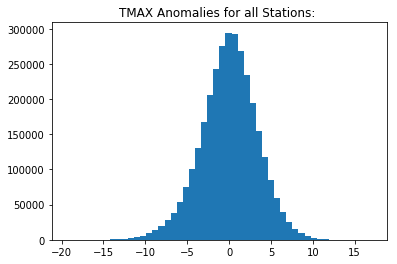

,YYYY,MM,DD,TMAX,TMIN,PRCP,SNOW,SNWD,date,jday,TMAXANOM
HOT,,,,,,,,,,,
0,3151862,3151862,3151862,3099760,3080509,3114930,2869264,2844689,3151862,3151862,3099760
1,79322,79322,79322,79322,78218,78475,71086,70486,79322,79322,79322


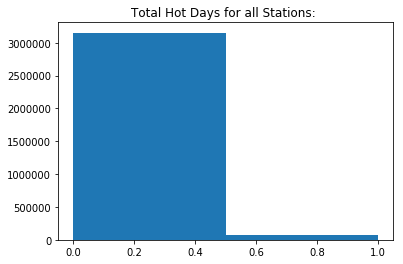

In [8]:
# Concat all stations together
ghcnd_all_stn = pd.concat(ghcnd_list)
#print (ghcnd_all_stn)


plt.hist(ghcnd_all_stn['TMAXANOM'].dropna(), bins=50, cumulative=False, normed=False)
plt.title('TMAX Anomalies for all Stations: ')
plt.show()
plt.hist(ghcnd_all_stn['HOT'].dropna(), bins=2, cumulative=False, normed=False)
plt.title('Total Hot Days for all Stations: ')


#print(ghcnd_all_stn['HOT'].value_counts)
ghcnd_all_stn.groupby('HOT').count()



## 2- IMPORT SST ANOMALIES ( IMAGES)
testing_x and testing_y data as **train_all_year** and **test_all_year**

In [9]:
# Read SST anomalies data for the selected years. (training_dataset) ~30 mins

lead_time = 10 # Lead times of 10 day for now!

sst_train_list = []
sst_test_list= []

# SST ocean region
lat_lims = [20.,50.]
lon_lims = [145.,230.]

#end_year = 1984
#print (end_year)

# Process data year by year and append each year to the sst_list
for yr in tqdm(range(start_year, end_year+1)):
        #print ('------------------------------------------------------------------')
        if (yr != 2000):
            #  sst_name = "sst.day.anom."+str(yr)+".nc" # file name
            sst_year = process_sst_data (sst_dir, yr, start_doy, end_doy, \
                                  lead_time, lat_lims, lon_lims)
            sst_train_list.append(sst_year)
        if (yr == 2000):
            sst_test_list = sst_year

            
            
###foo = np.column_stack((sst_year, sst_year2))

train_all_years = np.concatenate(sst_train_list)
print ('Minimum for all training years is: (INCLUDES fill values) '
       + str(np.min(train_all_years)))

## REMOVING MISSING VALUES FROM .NC FILE WITH 0 
## when we converted the numpy array to list it did not know that some values were missing as --
## so it returned -9.96921e+36 for it. 

index = np.argwhere(train_all_years == np.min(train_all_years))
for i in index:
    train_all_years[tuple(i)] = 0

print ('Minimum for all training years AFTER removing fill values or NANs with 0 is:'
       + str(np.min(train_all_years)))
## printing 'index' will give you the index or coordinates of the fill (missing) values. 

## TEST YEARS:
## IF TEST YEARS IS MORE THAN ONE (2012 for now run this part:)
#test_all_years = np.concatenate(sst_test_list)
#print (test_all_years.shape)
#index = np.argwhere(test_all_years == np.min(test_all_years))
#for i in index:
#    test_all_years[tuple(i)] = 0
#    
#print (test_all_years.shape)

## ELSE:

test_all_years= np.array(sst_test_list)


100%|██████████| 34/34 [33:51<00:00, 59.76s/it]


Minimum for all training years is: (INCLUDES fill values) -9.96921e+36
Minimum for all training years AFTER removing fill values or NANs with 0 is:-8.15


In [10]:
print (np.min(test_all_years))

index = np.argwhere(test_all_years == np.min(test_all_years))
for i in index:
    test_all_years[tuple(i)] = 0
print (np.min(test_all_years))



-9.96921e+36
-4.5299997


##  Quality Control and Checking Data for SST (IMAGES)

### 1) Mapping SST Anomalies Data

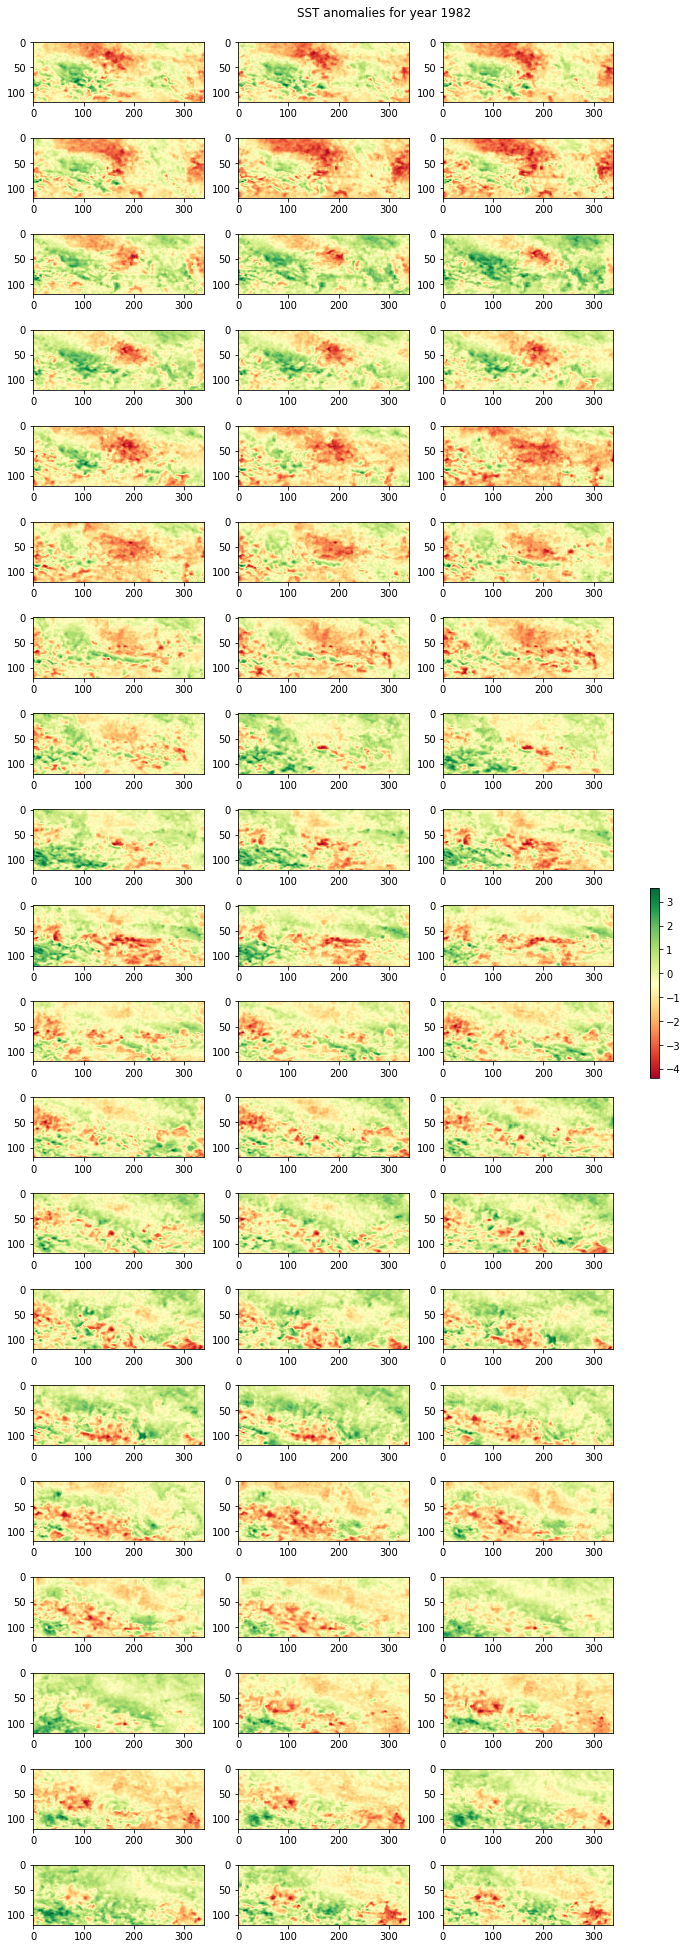

In [11]:
import matplotlib.cm as cm

fig, axs = plt.subplots(20,3, figsize=(13, 35), facecolor='w', edgecolor='k')

axs = axs.ravel()

for i in range(60):
    im = axs[i].imshow(train_all_years[i,:,:],cmap=cm.RdYlGn);

##ADD GLOBAL colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.1)

## ADD global title 
plt.suptitle("SST anomalies for year 1982", y=0.89)

plt.show()

### 2) Mins and Maxes of SST Anomalies



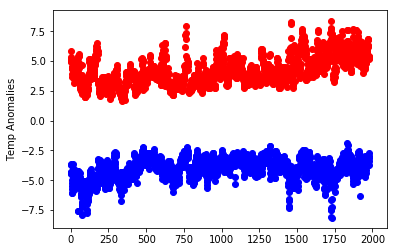

In [12]:
#for i in range(len(train_all_years)):
    #print (np.min(train_all_years[i,:,:]),np.max(train_all_years[i,:,:]))
sst_mins = list(([np.min(train_all_years[i,:,:])] for i in range(len(train_all_years))))
sst_maxs = list(([np.max(train_all_years[i,:,:])] for i in range(len(train_all_years))))
x_axis = range (0,len(sst_mins))

plt.scatter(x_axis,sst_mins,color='b')
plt.scatter(x_axis,sst_maxs,color='r')
plt.ylabel('Temp Anomalies')
plt.show();

## I) Making TRAIN_Y, TEST_Y (LABELS)

/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


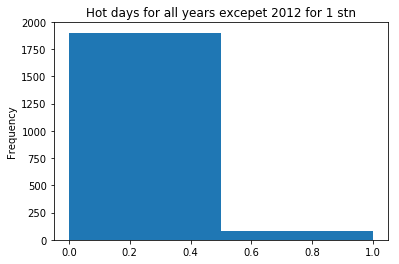

/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


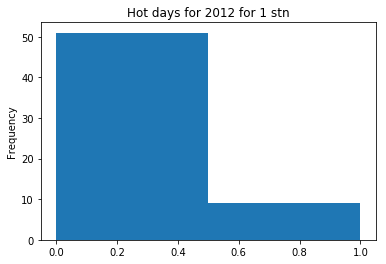

/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [13]:
# Y Testing Data Set: test_all_stn
# Y Training Data Set: train_all_stn

# Y Training and Testing Data Set: train_all_stn 
#### Below is only for one station. This is just for now. 
##In future we want this to be labels= train_all_stn['TMAXANOM']
    #train_all_stn = ghcnd_all_stn[ghcnd_all_stn.YYYY != 2012]
    #train_all_stn.groupby('YYYY').count()
        
    #test_all_stn = ghcnd_all_stn[ghcnd_all_stn.YYYY == 2012]
    #test_all_stn.groupby('YYYY').count()

## Labels or Y Training and Y Testing for one station
ii = 549  # one sample station is randomly chosen this was a hot station. ;-)

train_one_stn = ghcnd_list[ii][ghcnd_list[ii].YYYY != 2012]
train_one_stn.groupby('YYYY').count()
        
test_one_stn = ghcnd_list[ii][ghcnd_list[ii].YYYY == 2012]
test_one_stn.groupby('YYYY').count()

###
labels = train_one_stn['HOT']

###print (train_one_stn.groupby('YYYY'))
plt.hist(labels, bins=2, cumulative=False, normed=False)
plt.title("Hot days for all years excepet 2012 for 1 stn")
plt.ylabel("Frequency")
plt.show();

#print (labels.values)
##print (labels.shape)
train_y =labels.reshape(-1,1)
#print (train_y.shape)

###print ('maximimu TMAX anomaly for one stations is :'+str(np.amax(train_y)))
###print ('minimum TMAX anomaly one stations is :'+str(np.amin(train_y)))

del (labels)
labels = test_one_stn['HOT']


plt.hist(labels, bins=2, cumulative=False, normed=False)
plt.title("Hot days for 2012 for 1 stn")
plt.ylabel("Frequency")
plt.show()

###print ('maximimu TMAX anomaly for 1 stn for test is :'+str(np.amax(labels)))
###print ('minimum TMAX anomaly 1 stn for test:'+str(np.amin(labels)))

test_y =labels.reshape(-1,1)
#print (test_y.shape)

## II) Making TRAIN_X, TEST_X (IMAGES)

In [71]:
# X Training Data Set from sst_train_list

#print (np.min(train_all_years))
print(train_all_years.shape)
#train_x= train_all_years.reshape(-1,120,340)
train_x= train_all_years.reshape(-1,120,340, 1)

# X testing Data Set from sst_all_test

test_x= test_all_years.reshape(-1,120,340, 1)
#test_x= a.reshape(-1,1,120,340)

#print (train_x.shape)
#print (test_x.shape)

(1980, 120, 340)


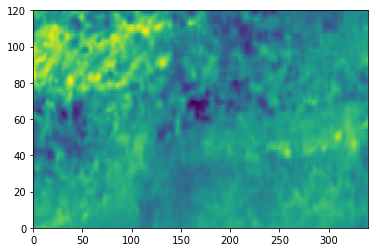

In [73]:
plt.pcolormesh(train_x[25, :, :, 0])

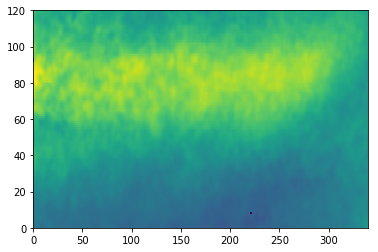

In [114]:
plt.pcolormesh(train_x.std(axis=0)[: ,:, 0])

In [116]:
norm_train_x_2 = (train_x - train_x.mean(axis=0)) / train_x.std(axis=0)
norm_test_x_2 = (test_x - train_x.mean(axis=0)) / train_x.std(axis=0)

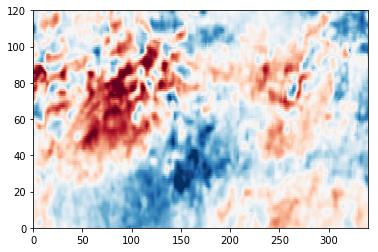

In [119]:
plt.pcolormesh(norm_train_x[0, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

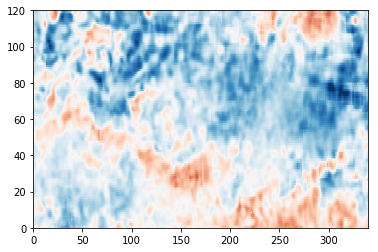

In [121]:
plt.pcolormesh(norm_train_x_2[355, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

## Quality control for legends data (GHCND)


We might have some NaNs for some missing label(station ) data for example missing data for some years. 

In [15]:
print(' Count of non-NAN data :' + str(np.count_nonzero(~np.isnan(train_y))))
print(' Count of NAN data :' + str(np.count_nonzero(np.isnan(train_y))))


## Removing SST data if there were any NAN legends(NAN GHCND)

ja= np.argwhere(np.isnan(train_y))
train_y = np.delete(train_y,ja,axis=0)
train_x= np.delete(train_x,ja,axis=0)
print (train_y.shape)
print (train_x.shape)
print(' Count of NAN data AFTER removal of NANS:' + 
      str(np.count_nonzero(np.isnan(train_y))))



 Count of non-NAN data :1980
 Count of NAN data :0
(1980, 1)
(1980, 1, 120, 340)
 Count of NAN data AFTER removal of NANS:0


## Data Normalization

In [76]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
        for i in range(data.shape[-1]):
            scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
    for i in range(data.shape[-1]):
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [77]:
norm_train_x, scaling_values_train = normalize_multivariate_data(train_x)

norm_test_x, scaling_values_test = \
                normalize_multivariate_data(test_x, scaling_values_train)

print (norm_train_x.shape)
print (norm_test_x.shape)
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!##
## Here Scaling Value for both train and test are technically the same. 

    
### NORMALIZING WITH TRAINING_SCALING_VALUES MIGHT BE WRONG

(1980, 120, 340, 1)
(60, 120, 340, 1)


/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


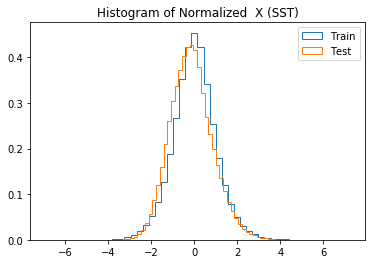

In [66]:
plt.hist(norm_train_x.reshape(-1,340).ravel(), bins=50, cumulative=False, normed=True,histtype='step',label='Train');
#plt.title('Histogram of Normalized Training X (SST)')
#plt.show

plt.hist(norm_test_x.reshape(-1,340).ravel(), bins=50, cumulative=False, normed=True,histtype='step',label='Test');
#plt.title('Histogram of Normalized Testing X (SST)')
#plt.show
plt.title('Histogram of Normalized  X (SST)')

plt.legend(loc='upper right')
plt.show()


##  Deep Neural Network


In [19]:
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, Flatten, LeakyReLU
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

/Users/negins/miniconda3/envs/deeper/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Here we used Brier score and Brier Skill score to for measuring the accuracy of our models. 

Please refer to the following link for more information on brier skill score, ROC:
https://www.nssl.noaa.gov/users/brooks/public_html/feda/papers/skill_overest_hamill_juras.pdf

*** I will put more infor about brier skill scores here. (note to self)

In [ ]:
def brier_score_keras(obs, preds):
    return K.mean((preds - obs) ** 2)

def brier_skill_score_keras(obs, preds):
    climo = K.mean((obs - K.mean(obs)) ** 2)
    return 1.0 - brier_score_keras(obs, preds) / climo

In [122]:
# Input layer
dense_in = Input(shape=norm_train_x.shape[1:])
# Flatten input layer into long vector
dense = AveragePooling2D(pool_size=(32, 32))(dense_in)
dense = Flatten()(dense)
# First hidden layer
dense = Dropout(0.5)(dense)
dense = Dense(16, kernel_regularizer=l2(0.0001))(dense)
# Activation function for first hidden layer
dense = Activation("selu")(dense)
dense = Dropout(0.5)(dense)
#dense = BatchNormalization()(dense)
# Second Hidden layer
dense = Dense(16, kernel_regularizer=l2(0.0001))(dense)
dense = Activation("selu")(dense)
dense = Dropout(0.5)(dense)
#dense = BatchNormalization()(dense)

# Output layer
dense = Dense(1)(dense)
dense = Activation("sigmoid")(dense)
# Creates a model object that links input layer and output
dense_model = Model(dense_in, dense)
# Optimizer object
opt_dense = SGD(lr=0.0001, momentum=0.99, decay=1e-4, nesterov=True)
# Compile model with optimizer and loss function
dense_model.compile(opt_dense, "mse", metrics=[brier_skill_score_keras])

In [93]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 120, 340, 1)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 3, 10, 1)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 30)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                496       
_________________________________________________________________
activation_34 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
__________

### Checking Model Architecture

#### Checking Model Archtiecture in Jupyter Notebook. 
This shows the out put in the notebook but does not inclued info on dimensions of each layers.

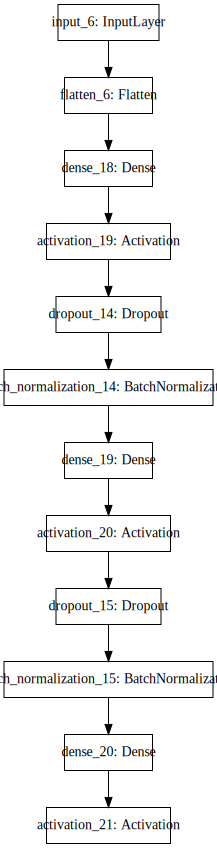

In [56]:
#Checking Model Archtiecture in Jupyter
SVG(model_to_dot(dense_model).create(prog='dot', format='svg'))

#### Saving Model Archtiecture as png files.
This saves the model architecture as a png file. This png file includes dimentions of each layer. 

In [ ]:
## Saving Model Archtiecture outside in png. 
##(Shows dimensions as WELL)
model_architecture_name = "dense_test_DJ_13"
plot_model(dense_model, to_file='model_architecture_nam', show_shapes=True, show_layer_names=True)

In [57]:
## One Last check of Test and Trainging Dataset dimensions:

print (norm_train_x.shape)
print (norm_test_x.shape)
print (test_y.shape)
print (train_y.shape)


(1980, 1, 120, 340)
(60, 1, 120, 340)
(60, 1)
(1980, 1)


In [124]:
dense_hist = dense_model.fit(norm_train_x_2, train_y, 
                             batch_size=256, epochs=150, verbose=2,
                             validation_data=(norm_test_x_2, test_y))

Train on 1980 samples, validate on 60 samples
Epoch 1/150
 - 1s - loss: 0.3167 - brier_skill_score_keras: -7.8271e+00 - val_loss: 0.1841 - val_brier_skill_score_keras: -4.1440e-01
Epoch 2/150
 - 1s - loss: 0.3276 - brier_skill_score_keras: -8.2428e+00 - val_loss: 0.1830 - val_brier_skill_score_keras: -4.0535e-01
Epoch 3/150
 - 1s - loss: 0.3175 - brier_skill_score_keras: -7.7410e+00 - val_loss: 0.1817 - val_brier_skill_score_keras: -3.9516e-01
Epoch 4/150
 - 1s - loss: 0.3205 - brier_skill_score_keras: -7.5885e+00 - val_loss: 0.1803 - val_brier_skill_score_keras: -3.8441e-01
Epoch 5/150
 - 1s - loss: 0.3263 - brier_skill_score_keras: -8.0977e+00 - val_loss: 0.1788 - val_brier_skill_score_keras: -3.7292e-01
Epoch 6/150
 - 1s - loss: 0.3117 - brier_skill_score_keras: -7.6648e+00 - val_loss: 0.1773 - val_brier_skill_score_keras: -3.6076e-01
Epoch 7/150
 - 1s - loss: 0.3137 - brier_skill_score_keras: -7.4919e+00 - val_loss: 0.1756 - val_brier_skill_score_keras: -3.4786e-01
Epoch 8/150
 - 1

Epoch 63/150
 - 1s - loss: 0.1483 - brier_skill_score_keras: -3.1465e+00 - val_loss: 0.1261 - val_brier_skill_score_keras: 0.0405
Epoch 64/150
 - 1s - loss: 0.1557 - brier_skill_score_keras: -3.3912e+00 - val_loss: 0.1260 - val_brier_skill_score_keras: 0.0411
Epoch 65/150
 - 1s - loss: 0.1473 - brier_skill_score_keras: -2.8822e+00 - val_loss: 0.1260 - val_brier_skill_score_keras: 0.0416
Epoch 66/150
 - 1s - loss: 0.1493 - brier_skill_score_keras: -3.2416e+00 - val_loss: 0.1259 - val_brier_skill_score_keras: 0.0421
Epoch 67/150
 - 1s - loss: 0.1442 - brier_skill_score_keras: -2.7168e+00 - val_loss: 0.1258 - val_brier_skill_score_keras: 0.0426
Epoch 68/150
 - 1s - loss: 0.1383 - brier_skill_score_keras: -3.0969e+00 - val_loss: 0.1258 - val_brier_skill_score_keras: 0.0430
Epoch 69/150
 - 1s - loss: 0.1351 - brier_skill_score_keras: -3.2081e+00 - val_loss: 0.1257 - val_brier_skill_score_keras: 0.0434
Epoch 70/150
 - 1s - loss: 0.1431 - brier_skill_score_keras: -3.2195e+00 - val_loss: 0.125

Epoch 126/150
 - 1s - loss: 0.0847 - brier_skill_score_keras: -1.2013e+00 - val_loss: 0.1265 - val_brier_skill_score_keras: 0.0368
Epoch 127/150
 - 1s - loss: 0.0848 - brier_skill_score_keras: -1.1999e+00 - val_loss: 0.1266 - val_brier_skill_score_keras: 0.0366
Epoch 128/150
 - 1s - loss: 0.0889 - brier_skill_score_keras: -1.3158e+00 - val_loss: 0.1266 - val_brier_skill_score_keras: 0.0364
Epoch 129/150
 - 1s - loss: 0.0862 - brier_skill_score_keras: -1.3769e+00 - val_loss: 0.1266 - val_brier_skill_score_keras: 0.0362
Epoch 130/150
 - 1s - loss: 0.0850 - brier_skill_score_keras: -1.2705e+00 - val_loss: 0.1266 - val_brier_skill_score_keras: 0.0361
Epoch 131/150
 - 1s - loss: 0.0860 - brier_skill_score_keras: -1.6149e+00 - val_loss: 0.1267 - val_brier_skill_score_keras: 0.0359
Epoch 132/150
 - 1s - loss: 0.0847 - brier_skill_score_keras: -1.3246e+00 - val_loss: 0.1267 - val_brier_skill_score_keras: 0.0357
Epoch 133/150
 - 1s - loss: 0.0860 - brier_skill_score_keras: -1.2310e+00 - val_los

Text(0.5,1,'Dense Net Training History')

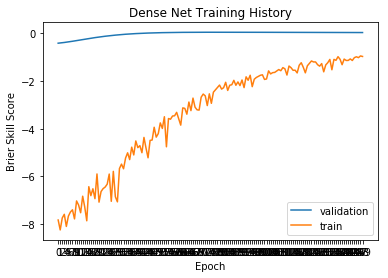

In [125]:
plt.plot(dense_hist.epoch, dense_hist.history["val_brier_skill_score_keras"], label="validation")
plt.plot(dense_hist.epoch, dense_hist.history["brier_skill_score_keras"], label="train")
plt.xticks(dense_hist.epoch)
#plt.ylim(-1, 1)
plt.legend()
plt.ylabel("Brier Skill Score")
plt.xlabel("Epoch")
plt.title("Dense Net Training History")

Brier skill score - Equation for Brier skill score

Answers the question: What is the relative skill of the probabilistic forecast over that of climatology, in terms of predicting whether or not an event 
occurred?

Range: minus infinity to 1, 0 indicates no skill when compared to the reference forecast. Perfect score: 1.

In [109]:
dense_model.predict(norm_test_x)

array([[0.12395339],
       [0.12056306],
       [0.11774901],
       [0.12280401],
       [0.11318164],
       [0.102571  ],
       [0.09473225],
       [0.09268159],
       [0.09229391],
       [0.09571158],
       [0.10530747],
       [0.11076666],
       [0.10451034],
       [0.10032193],
       [0.09969439],
       [0.0977038 ],
       [0.09343509],
       [0.09636042],
       [0.10447572],
       [0.10919287],
       [0.11077449],
       [0.11241832],
       [0.11374024],
       [0.1197939 ],
       [0.12186708],
       [0.1182955 ],
       [0.11456706],
       [0.11043161],
       [0.1078283 ],
       [0.10525741],
       [0.10332906],
       [0.1026482 ],
       [0.10577741],
       [0.10104372],
       [0.09628907],
       [0.09978894],
       [0.10298989],
       [0.10000318],
       [0.09681474],
       [0.09436468],
       [0.09563579],
       [0.09014109],
       [0.09056089],
       [0.0921973 ],
       [0.09333982],
       [0.09211202],
       [0.09484905],
       [0.097

In [128]:
score = dense_model.evaluate(norm_test_x_2, test_y, verbose=1)



60/60 [==============================] - 0s 365us/step


In [129]:
print (score)

[0.1271777664621671, -0.1070881207784017]


In [169]:
score, acc = dense_model.evaluate(test_x, test_y)



60/60 [==============================] - 0s 592us/step


*** Note to self: Include ROC calculations from ML algorithms here. 